In [1]:


from datasets import load_dataset
from transformers import CLIPVisionModelWithProjection, CLIPTextModelWithProjection

from transformers import CLIPTokenizerFast


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


model = CLIPVisionModelWithProjection.from_pretrained("clep_trainer/checkpoint-74/")

map_digit_to_token = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}

tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-large-patch14")

map_digit_to_input_ids = {
    digit: tokenizer(f"{map_digit_to_token[digit]}", padding=True).input_ids
    for digit in range(10)
}

# import torch

# inputs = {
#     "pixel_values": processor(images=images, return_tensors="pt").pixel_values,
#     "input_ids": torch.tensor([map_digit_to_input_ids[digit] for digit in range(10)]),
#     "attention_mask": torch.tensor([[1] * 3] * 10),
# }
# outputs = model(**inputs, return_loss=True)
# logits_per_image = outputs.logits_per_image
# probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities


In [3]:
text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")


In [4]:
import torch


In [5]:
map_digit_to_embedding = {
    digit: text_model(
        input_ids=torch.tensor(map_digit_to_input_ids[digit]).unsqueeze(0),
        attention_mask=torch.ones(1, 3),
    ).text_embeds
    for digit in range(10)
}


In [6]:
embeddings = torch.concat([map_digit_to_embedding[digit] for digit in range(10)])


<Axes: >

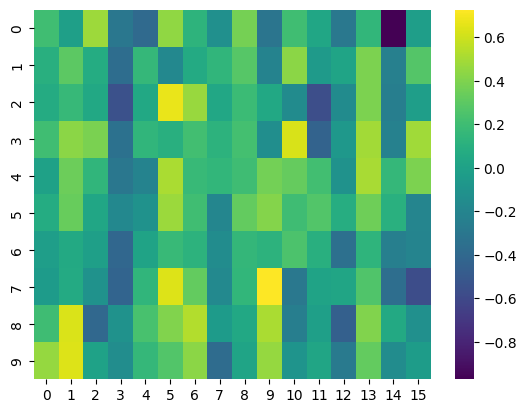

In [7]:
import seaborn as sns

sns.heatmap(embeddings.detach().numpy()[:, :16], cmap="viridis")


In [8]:
preprocessed_dataset = load_dataset("eeg_mnist_preprocessed", keep_in_memory=True, split="test")


Resolving data files: 100%|██████████| 56/56 [00:00<00:00, 590153.33it/s]

In [9]:
from torch.utils.data import DataLoader


In [10]:
model.eval()
model.to("cuda")


CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(5, 16, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(325, 16)
    )
    (pre_layrnorm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-1): 2 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=16, out_features=16, bias=True)
            (v_proj): Linear(in_features=16, out_features=16, bias=True)
            (q_proj): Linear(in_features=16, out_features=16, bias=True)
            (out_proj): Linear(in_features=16, out_features=16, bias=True)
          )
          (layer_norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=16, out_features=64, bias=True)
          

In [11]:
embeddings = embeddings.to("cuda")


In [12]:
TP = 0
N = 0
for inputs in DataLoader(preprocessed_dataset.with_format("torch"), batch_size=64):
    labels = inputs.pop("labels").to("cuda")
    with torch.no_grad():
        outputs = model(pixel_values=inputs["pixel_values"].to("cuda"))
    probs = (embeddings @ outputs.image_embeds.T).softmax(dim=0)
    prediction = probs.argmax(dim=0)
    TP += (prediction == labels).sum().item()
    N += len(labels)
    print(f"Accuracy: {TP / N:.3f}", end="\r")


In [13]:
tokenized = [
    map_digit_to_input_ids[digit]
    for digit in range(10)
]
tokenized = torch.tensor(tokenized).to("cuda")


In [14]:
attention_mask = torch.ones_like(tokenized).to("cuda")


In [15]:
from transformers import CLIPModel
model = CLIPModel.from_pretrained("clep_trainer/checkpoint-147/")
model.to("cuda")


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [16]:
TP = 0
N = 0
for inputs in DataLoader(preprocessed_dataset.with_format("torch"), batch_size=64):
    labels = inputs.pop("labels").to("cuda")
    with torch.no_grad():
        outputs = model(input_ids=tokenized, attention_mask=attention_mask, pixel_values=inputs["pixel_values"].to("cuda"))
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)
    prediction = probs.argmax(dim=1)
    TP += (prediction == labels).sum().item()
    N += len(labels)
    print(f"Accuracy: {TP / N:.3f}", end="\r")


In [17]:
embeddings.shape


torch.Size([10, 768])

In [18]:
i = 10


In [19]:
labels[i]


tensor(3, device='cuda:0')

<Axes: >

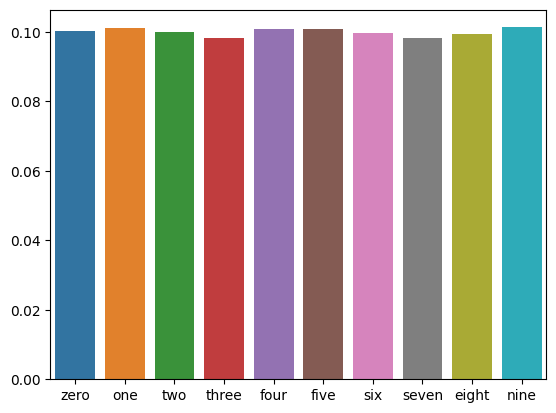

In [20]:
sns.barplot(
    x=[map_digit_to_token[digit] for digit in range(10)],
    y=probs[i].squeeze().detach().cpu().numpy(),
)


In [21]:
probs = (embeddings @ outputs.image_embeds.T).softmax(dim=0)
prediction = probs.argmax(dim=0)
prediction


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], device='cuda:0')

In [22]:
outputs.image_embeds.shape


torch.Size([54, 768])